# Libraries and Referenced Functions

In [1]:
#https://www.kaggle.com/c/kobe-bryant-shot-selection

In [18]:
# https://www.kaggle.com/dixhom/data-analysis-for-beginners

import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import random
import seaborn as sns
%matplotlib inline

random.seed(123)

The following are functions that have been taken from previous submissions.

In [2]:
def draw_court(ax=None, color='black', lw=2, outer_lines=True):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [3]:
def scatter_plot_by_category(feat, df):
    alpha = 0.1
    gs = df.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# Feature Engineering, Vectorisation and Data Cleaning

Here I have removed a number of features that will be surplus to requirements, using `to_drop`. Furthermore, we can filter the data to remove null entries in `shot_made_flag`. For algorithms using strictly continuous data, all discrete features are filtered out. `shot_id` has been left in the data frame purely for indexing, it should not be used as a feature. `angle` is the angle between the court and the shot trajectory which can be used as a continous-valued feature.


### `to_drop`
* `minutes_remaining` and `seconds_remaining` replaced with `secs_from_period_end` which is more useful.
* `team_id`, `team_name`, and `matchup` all contain effectively the same information because Kobe only played for one team and we have `opponent` as a feature.
* `lon` and `lat` represents the same data as `loc_x` and `loc_y` in a less clear format.
* `game_id` and `game_event_id`  is almost certainly independent of `shot_made_flag`. This can be proven (prove it)
* `game_date` is likely to be too specific to have a relationship `shot_made_flag`, so we will use `season` as our only time-based feature.
* `period` has been removed because the data represents extra time as its own period which makes the period irrelevant.
* `playoffs` has been removed since Kobe's shot accuracy between a play off game and non-play off game is the same to 2 decimal places, as demonstrated by Cai Yeming.

All the shot zone features `'shot_zone_area', 'shot_zone_basic', 'shot_zone_range'` can effectively be represented using `dist` and `angle`.

In [24]:
df_raw = pd.read_csv("data.csv")
df = df_raw.copy()

df = df[pd.notnull(df['shot_made_flag'])]

df['secs_from_period_end']   = 60*df['minutes_remaining']+df['seconds_remaining']
df['secs_from_period_start'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['secs_from_start']   = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['secs_from_period_start']
df['dist'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)
df['away/home'] = df['matchup'].str.contains('vs').astype('int')
df['game_date'] = pd.to_datetime(df['game_date'])
df['game_year'] = df['game_date'].dt.year

loc_x_zero = (df['loc_x'] == 0)

df['angle'] = np.array([0]*len(df))
df['angle'][~loc_x_zero] = np.arctan(df['loc_y'][~loc_x_zero] / df['loc_x'][~loc_x_zero])
df['angle'][loc_x_zero] = np.pi / 2

to_drop = ['period', 'minutes_remaining', 'seconds_remaining', 'team_id', 'team_name', 'matchup', 'lon', 'lat',
           'game_id', 'game_event_id', 'game_date', 'playoffs', 'shot_distance', 'secs_from_period_start', 'season', 'game_date']

#df.set_index('shot_id', inplace=True)

df = df.drop(to_drop, axis = 1)

# under_10_secs = (df['secs_from_period_end'] < 10)==True
# under_10 = [int(i) for i in under_10_secs]
# last_10_bool = df[under_10_secs]
# df['last_10s'] = under_10

categorical_cols = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area',
                        'shot_zone_basic', 'shot_zone_range', 'opponent']

for col in categorical_cols:
    dummies = pd.get_dummies(df[col])
    dummies = dummies.add_prefix("{}_".format(col))
    df.drop(col, axis=1, inplace=True)
    df = df.join(dummies)

C:\Users\bubba_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bubba_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
df.columns[:20]

Index(['loc_x', 'loc_y', 'shot_made_flag', 'shot_id', 'secs_from_period_end',
       'secs_from_start', 'dist', 'away/home', 'game_year', 'angle',
       'action_type_Alley Oop Dunk Shot', 'action_type_Alley Oop Layup shot',
       'action_type_Cutting Layup Shot', 'action_type_Driving Bank shot',
       'action_type_Driving Dunk Shot',
       'action_type_Driving Finger Roll Layup Shot',
       'action_type_Driving Finger Roll Shot',
       'action_type_Driving Floating Bank Jump Shot',
       'action_type_Driving Floating Jump Shot',
       'action_type_Driving Hook Shot'],
      dtype='object')

The following suggests the last seconds of a period are the least accurate. This should be accounted for.

In [5]:
# # Length of period is 720

# for n in range(1, 100, 5):
#     under_n_secs = ((df['secs_from_period_end'] < n)==True)
#     print('Accuracy in last', n, 'seconds of period:', round(df[under_n_secs]['shot_made_flag'].mean()*100), '%')

### Court Visualisation

Text(0.5, 1.0, 'shot_zone_range')

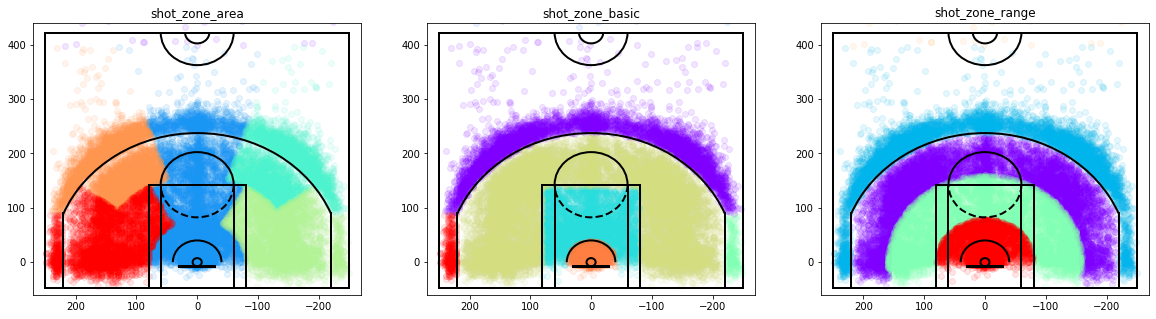

In [6]:
plt.figure(figsize=(20,5))

# shot_zone_area
plt.subplot(131)
draw_court(); plt.ylim(-60,440); plt.xlim(270,-270)
scatter_plot_by_category('shot_zone_area', df_raw)
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
draw_court(); plt.ylim(-60,440); plt.xlim(270,-270)
scatter_plot_by_category('shot_zone_basic', df_raw)
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
draw_court(); plt.ylim(-60,440); plt.xlim(270,-270)
scatter_plot_by_category('shot_zone_range', df_raw)
plt.title('shot_zone_range')

In [7]:
y = df['shot_made_flag'].copy()
X = df.drop(['shot_made_flag'], axis = 1)

x_tr, x_test, y_tr, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.3)

### Measuring Importance of Features

In [8]:
threshold = 0.90
vt = VarianceThreshold().fit(x_tr)

# Most important features
# feat_var_threshold = X.columns[vt.variances_ > threshold * (1-threshold)]
# feat_var_threshold
# feature_imp = pd.DataFrame(model.feature_importances_, index=x_tr.columns, columns=["importance"])
# feature_imp

### Cross Validation and Combining Algorithm Results

In [13]:
models = []
preds = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier(n_estimators=100, max_depth=10)))
models.append(('BNB', BernoulliNB()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))


for name, model in models:
    #CrossValidator()
    preds.append(model.fit(x_tr, y_tr).predict(x_test))

C:\Users\bubba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
master_pred = sum(preds)

for i in range(len(master_pred)):
    if master_pred[i] >= len(preds)/2:
        master_pred[i] = 1
    else:
        master_pred[i] = 0


#preds.append(master_pred)

for i, pred in enumerate(preds):
    print(models[i][0], 'accuracy:', round(accuracy_score(y_test, pred), 3), '| F-score:', round(f1_score(y_test, pred), 3))
print('Combined accuracy:',round(accuracy_score(y_test, master_pred), 3), '| F-score:', round(f1_score(y_test, master_pred), 3))

LR accuracy: 0.687 | F-score: 0.566
RFC accuracy: 0.688 | F-score: 0.57
BNB accuracy: 0.651 | F-score: 0.537
DTC accuracy: 0.593 | F-score: 0.542
NB accuracy: 0.635 | F-score: 0.492
Combined accuracy: 0.676 | F-score: 0.559
